# Final Project
### Author: Maryam Zad 
### Table of Contents
1. [Data Preperation](#data-preperation)
2. [Hashtag Classification](#hashtag-classification)
3. [Merging Hashtag Labels Into User Posts](#merging-hashtag-labels-into-user-posts)
4. [Hashtag Time-Series Behavior](#hashtag-time-series-behavior)
5. [User-Level Behavior Analysis](#user-level-behavior-analysis)
6. [Exploratory Data Analysis](#exploratory-data-analysis)
7. [Modeling](#modeling)

## Data Preperation 

In [6]:
# identifying my 1000 users
# using this data 
import pandas as pd
df = pd.read_csv("user_post_summary.csv")


In [10]:
import hashlib

def anonymize_username(u):
    return hashlib.sha256(u.encode()).hexdigest()[:8]

df["username"] = df["username"].apply(anonymize_username)

In [3]:
df.head()

,username,total_posts,earliest_create_time,latest_create_time,days_diff
0,30b3e969,3924,2021-01-30 13:22:01,2025-02-12 18:53:07,1474.229931
1,87f9cdd3,2381,2020-10-24 11:22:10,2023-05-23 5:22:30,940.750232
2,c1f1d261,2026,2021-02-05 14:45:14,2023-05-07 11:43:28,820.873773
3,0c0212f9,1907,2022-10-14 14:54:13,2025-02-02 12:50:47,841.914282
4,d851eeaf,1795,2022-02-27 22:22:47,2025-01-10 22:37:29,1048.010208


In [11]:
# sort by long-term presence first, then number of posts
top1000_users = df.sort_values(
    by=["days_diff", "total_posts"], 
    ascending=False
).head(1000)

top1000_users


,username,total_posts,earliest_create_time,latest_create_time,days_diff
43510,a96a9d9a,11,2019-03-22 15:19:20,2024-12-06 14:15:39,2085.955775
6512,08429717,75,2019-07-02 20:34:52,2025-01-03 11:52:32,2011.637269
67568,efa13b29,6,2019-05-28 11:05:32,2024-11-20 15:56:33,2003.202095
27297,60ee415a,20,2019-07-06 17:34:29,2024-12-04 9:37:52,1977.669016
483,667084f6,324,2019-09-10 20:12:03,2025-01-10 19:15:17,1948.960579
...,...,...,...,...,...
145435,196dcd80,2,2020-11-06 21:22:22,2024-08-28 10:45:41,1390.557859
20863,c7f01246,26,2021-03-05 13:01:01,2024-12-24 22:43:24,1390.404433
49221,245f3537,9,2020-12-17 15:09:26,2024-10-07 23:37:40,1390.352940
48163,5e6dd7c6,10,2020-08-29 20:58:37,2024-06-19 22:30:50,1390.064039


In [8]:
# now grabbing the posts from the original big data set for only these users
selected_usernames = set(top1000_users["username"])
import json

filtered_posts = []

with open("all_posts_chronological_v2.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        post = json.loads(line)

        
        user = post.get("username")

        if user in selected_usernames:
            filtered_posts.append(post)

In [9]:
len(filtered_posts)

76842

## Hashtag Classification

In [52]:
# reading in the hashtag data
df1 = pd.read_csv("hashtags_more_than_30_users.csv")
print(df1.head())

        hashtag  hashtag_frequency  nr_unique_users  \
0          sahm            2454289           239461   
1           fyp             875165           116459   
2  momsoftiktok             812175            93640   
3       momlife             609597            78518   
4        momtok             433610            50713   

           first_encountered           last_encountered  unique_days  
0  2018-08-24 16:19:57+00:00  2025-05-25 23:59:58+00:00         2122  
1  2019-03-25 14:17:38+00:00  2025-05-25 23:59:58+00:00         1909  
2  2019-02-26 18:09:35+00:00  2025-05-25 23:57:29+00:00         1746  
3  2018-10-12 18:21:02+00:00  2025-05-25 23:59:13+00:00         1968  
4  2020-01-22 14:30:42+00:00  2025-05-25 23:58:41+00:00         1434  


In [13]:
# computing duration in days for each hashtag
df1["first_encountered"] = pd.to_datetime(df1["first_encountered"])
df1["last_encountered"] = pd.to_datetime(df1["last_encountered"])

df1["duration_days"] = (df1["last_encountered"] - df1["first_encountered"]).dt.days

In [14]:
df1.head()

,hashtag,hashtag_frequency,nr_unique_users,first_encountered,last_encountered,unique_days,duration_days
0,sahm,2454289,239461,2018-08-24 16:19:57+00:00,2025-05-25 23:59:58+00:00,2122,2466
1,fyp,875165,116459,2019-03-25 14:17:38+00:00,2025-05-25 23:59:58+00:00,1909,2253
2,momsoftiktok,812175,93640,2019-02-26 18:09:35+00:00,2025-05-25 23:57:29+00:00,1746,2280
3,momlife,609597,78518,2018-10-12 18:21:02+00:00,2025-05-25 23:59:13+00:00,1968,2417
4,momtok,433610,50713,2020-01-22 14:30:42+00:00,2025-05-25 23:58:41+00:00,1434,1950


In [15]:
df_clean = df1[df1["hashtag"] != "sahm"]

In [16]:
# computing thresholds 75th and 25th percentiles 
p75_unique = df_clean["unique_days"].quantile(0.75)
p25_unique = df_clean["unique_days"].quantile(0.25)

p75_duration = df_clean["duration_days"].quantile(0.75)
p25_duration = df_clean["duration_days"].quantile(0.25)


In [17]:
def classify_hashtag(row):
    if row["unique_days"] >= p75_unique and row["duration_days"] >= p75_duration:
        return "persistent"
    elif row["unique_days"] <= p25_unique or row["duration_days"] <= p25_duration:
        return "trendy"
    else:
        return "moderate"

df_clean["hashtag_category"] = df_clean.apply(classify_hashtag, axis=1)


/var/folders/yd/p6hvs29537q2mn162wlst19m0000gn/T/ipykernel_20586/3708319071.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["hashtag_category"] = df_clean.apply(classify_hashtag, axis=1)


In [18]:
filtered_posts_df = pd.DataFrame(filtered_posts)

In [19]:
filtered_posts_df["username"] = filtered_posts_df["username"].apply(anonymize_username)

In [20]:
filtered_posts_df.head()

,username,view_count,create_time,id,like_count,music_id,share_count,comment_count,hashtag_names,region_code,video_description,effect_ids,playlist_id,voice_to_text
0,2d393156,412,1545073089,6636038388136807686,15,6.635400e+18,0,0.0,"[featureme, foryou, toddlerlife, sahm, shesluc...",US,#ToddlerLife #ShesLuckyShesLoved #Featureme #F...,NaN,NaN,NaN
1,c8bceca2,629,1546299326,6641305032622869766,16,6.569006e+18,0,0.0,"[fitness, fitmom, nopainnogain, planetfitness,...",US,#nopainnogain #powerlifter #makinggoals #plane...,NaN,NaN,NaN
2,956eba2b,117,1546962758,6644154453815463174,11,2.225631e+17,1,2.0,"[foryou, witchdoctor, sahm]",US,I tried 😂 #witchdoctor #foryou #sahm,NaN,NaN,NaN
3,c8bceca2,230889,1548650239,6651402128826830085,33504,6.609122e+18,235,31.0,"[onceuponatime, ilovemykids, sahm, iamamom, fo...",US,Life of a stay at home mom! #onceuponatime #ia...,NaN,NaN,NaN
4,c8bceca2,1566,1548902399,6652485146366708998,275,6.647740e+18,1,3.0,"[gains, featurethis, momlife, sahm, fitmama, f...",US,Deadlifted 185lbs twice! #foryoupage #gains #f...,NaN,NaN,NaN


In [21]:
df_clean.head()

,hashtag,hashtag_frequency,nr_unique_users,first_encountered,last_encountered,unique_days,duration_days,hashtag_category
1,fyp,875165,116459,2019-03-25 14:17:38+00:00,2025-05-25 23:59:58+00:00,1909,2253,persistent
2,momsoftiktok,812175,93640,2019-02-26 18:09:35+00:00,2025-05-25 23:57:29+00:00,1746,2280,persistent
3,momlife,609597,78518,2018-10-12 18:21:02+00:00,2025-05-25 23:59:13+00:00,1968,2417,persistent
4,momtok,433610,50713,2020-01-22 14:30:42+00:00,2025-05-25 23:58:41+00:00,1434,1950,persistent
5,sahmlife,372520,57101,2019-02-05 22:22:42+00:00,2025-05-25 23:57:20+00:00,1729,2301,persistent


In [22]:
persistent_examples = df_clean[df_clean['hashtag_category'] == 'persistent']['hashtag'].unique()[:5]
moderate_examples   = df_clean[df_clean['hashtag_category'] == 'moderate']['hashtag'].unique()[:5]
trendy_examples     = df_clean[df_clean['hashtag_category'] == 'trendy']['hashtag'].unique()[:5]

persistent_examples, moderate_examples, trendy_examples


(array(['fyp', 'momsoftiktok', 'momlife', 'momtok', 'sahmlife'],
       dtype=object),
 array(['capcut', 'momcozy', 'momcozypump', 'fypシ゚viral', 'sahmtok'],
       dtype=object),
 array(['momcozylife', 'momcozybreastpump', 'creatorsearchinsights',
        'wearablepumps', 'momcozyla'], dtype=object))

In [23]:
filtered_posts_df.head()

,username,view_count,create_time,id,like_count,music_id,share_count,comment_count,hashtag_names,region_code,video_description,effect_ids,playlist_id,voice_to_text
0,2d393156,412,1545073089,6636038388136807686,15,6.635400e+18,0,0.0,"[featureme, foryou, toddlerlife, sahm, shesluc...",US,#ToddlerLife #ShesLuckyShesLoved #Featureme #F...,NaN,NaN,NaN
1,c8bceca2,629,1546299326,6641305032622869766,16,6.569006e+18,0,0.0,"[fitness, fitmom, nopainnogain, planetfitness,...",US,#nopainnogain #powerlifter #makinggoals #plane...,NaN,NaN,NaN
2,956eba2b,117,1546962758,6644154453815463174,11,2.225631e+17,1,2.0,"[foryou, witchdoctor, sahm]",US,I tried 😂 #witchdoctor #foryou #sahm,NaN,NaN,NaN
3,c8bceca2,230889,1548650239,6651402128826830085,33504,6.609122e+18,235,31.0,"[onceuponatime, ilovemykids, sahm, iamamom, fo...",US,Life of a stay at home mom! #onceuponatime #ia...,NaN,NaN,NaN
4,c8bceca2,1566,1548902399,6652485146366708998,275,6.647740e+18,1,3.0,"[gains, featurethis, momlife, sahm, fitmama, f...",US,Deadlifted 185lbs twice! #foryoupage #gains #f...,NaN,NaN,NaN


## Merging Hashtag Labels Into User Posts 

In [24]:
df_expanded = filtered_posts_df.explode("hashtag_names")

df_expanded = df_expanded.merge(
    df_clean[["hashtag", "hashtag_category"]],
    left_on="hashtag_names",
    right_on="hashtag",
    how="left"
)


In [25]:
df_expanded.head()

,username,view_count,create_time,id,like_count,music_id,share_count,comment_count,hashtag_names,region_code,video_description,effect_ids,playlist_id,voice_to_text,hashtag,hashtag_category
0,2d393156,412,1545073089,6636038388136807686,15,6.635400e+18,0,0.0,featureme,US,#ToddlerLife #ShesLuckyShesLoved #Featureme #F...,NaN,NaN,NaN,featureme,persistent
1,2d393156,412,1545073089,6636038388136807686,15,6.635400e+18,0,0.0,foryou,US,#ToddlerLife #ShesLuckyShesLoved #Featureme #F...,NaN,NaN,NaN,foryou,persistent
2,2d393156,412,1545073089,6636038388136807686,15,6.635400e+18,0,0.0,toddlerlife,US,#ToddlerLife #ShesLuckyShesLoved #Featureme #F...,NaN,NaN,NaN,toddlerlife,persistent
3,2d393156,412,1545073089,6636038388136807686,15,6.635400e+18,0,0.0,sahm,US,#ToddlerLife #ShesLuckyShesLoved #Featureme #F...,NaN,NaN,NaN,NaN,NaN
4,2d393156,412,1545073089,6636038388136807686,15,6.635400e+18,0,0.0,shesluckyshesloved,US,#ToddlerLife #ShesLuckyShesLoved #Featureme #F...,NaN,NaN,NaN,NaN,NaN


## Hashtag Time-Series Behavior

In [26]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

df_expanded['date'] = pd.to_datetime(df_expanded['create_time'], unit='s').dt.date

In [27]:
top_trendy = (
    df_expanded[df_expanded['hashtag_category'] == 'trendy']
    .hashtag.value_counts()
    .head(5)
    .index.tolist()
)
top_trendy


['creatorsearchinsights',
 'onthisday',
 'blackmomtent',
 'memecut',
 'oscarsathome']

In [28]:
tag = top_trendy[1]

In [29]:
ts = (
    df_expanded[df_expanded['hashtag'] == tag]
    .groupby('date')
    .size()
    .reindex(pd.date_range(df_expanded['date'].min(), df_expanded['date'].max()), fill_value=0)
)
ts.index = ts.index.date

In [30]:
peaks, _ = find_peaks(ts, height=np.percentile(ts, 90))   # peak = top 10% points

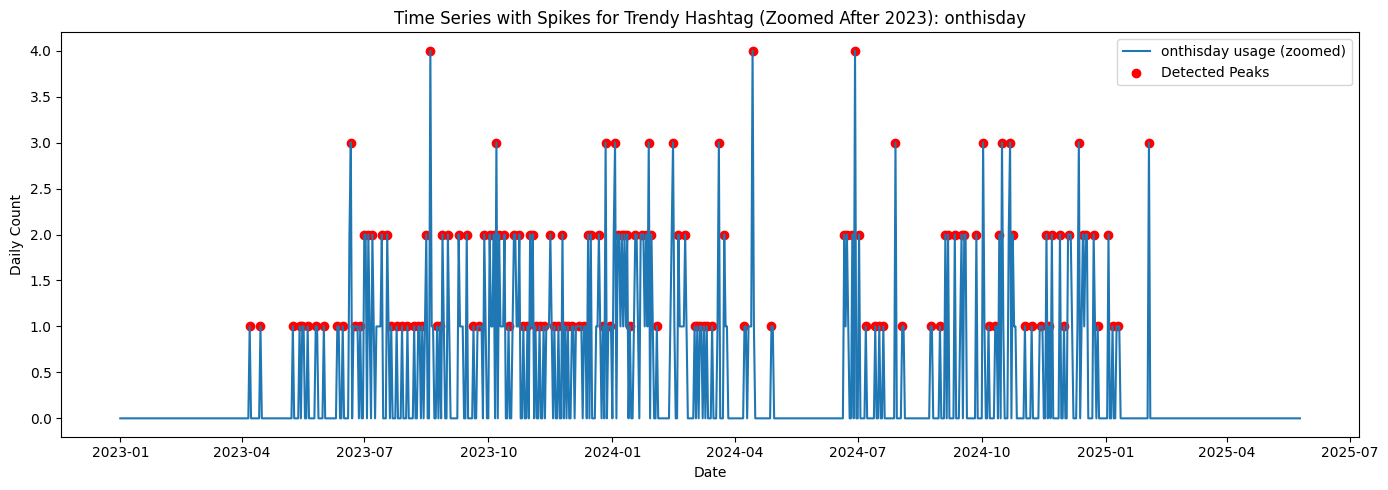

In [31]:
import datetime as dt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt


# specify cutoff date
cutoff = dt.date(2023, 1, 1)

# Filter the time series to show only data from your specefied date and onwards 
ts_zoom = ts[ts.index >= cutoff]

peaks_zoom, _ = find_peaks(ts_zoom.values)

# Plot zoomed-in time window
plt.figure(figsize=(14,5))
plt.plot(ts_zoom.index, ts_zoom.values, label=f"{tag} usage (zoomed)")
plt.scatter(ts_zoom.index[peaks_zoom], ts_zoom.values[peaks_zoom],
            color='red', label='Detected Peaks')

plt.title(f"Time Series with Spikes for Trendy Hashtag (Zoomed After 2023): {tag}")
plt.xlabel("Date")
plt.ylabel("Daily Count")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
top_persistent = (
    df_expanded[df_expanded['hashtag_category'] == 'persistent']
    .hashtag.value_counts()
    .head(5)
    .index.tolist()
)
top_persistent

['momsoftiktok', 'momlife', 'fyp', 'momtok', 'sahmlife']

In [33]:
tag = top_trendy[0]

In [34]:
ts = (
    df_expanded[df_expanded['hashtag'] == tag]
    .groupby('date')
    .size()
    .reindex(pd.date_range(df_expanded['date'].min(), df_expanded['date'].max()), fill_value=0)
)
ts.index = ts.index.date

In [35]:
peaks, _ = find_peaks(ts, height=np.percentile(ts, 90))   # peak = top 10% points

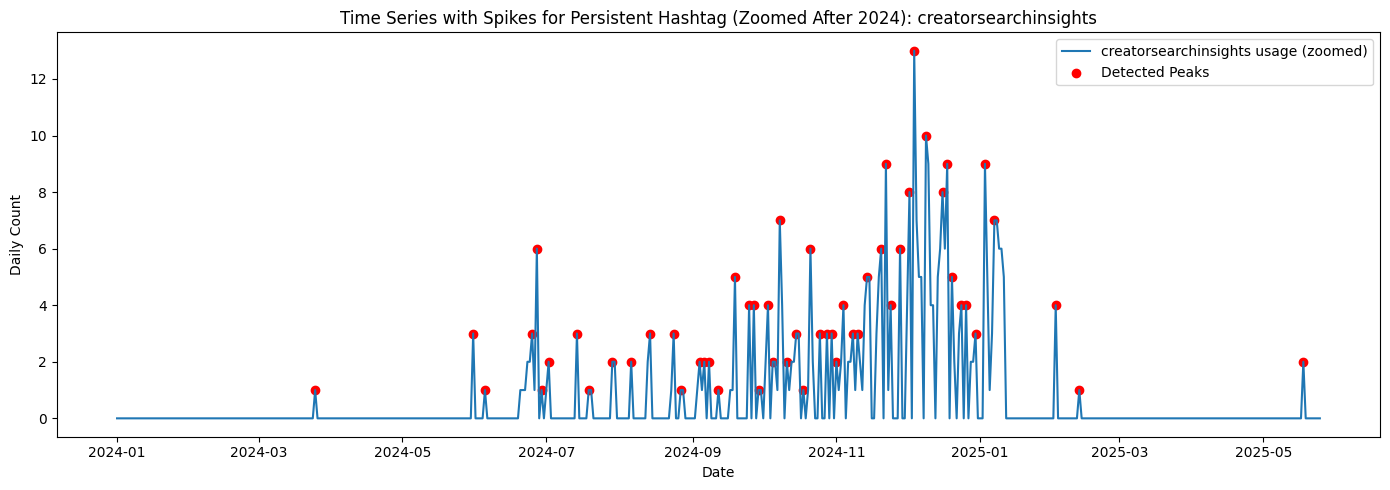

In [36]:
# specify cutoff date
cutoff = dt.date(2024, 1, 1)

# Filter the time series to show only data from your specefied date and onwards 
ts_zoom = ts[ts.index >= cutoff]

peaks_zoom, _ = find_peaks(ts_zoom.values)

# Plot zoomed-in time window
plt.figure(figsize=(14,5))
plt.plot(ts_zoom.index, ts_zoom.values, label=f"{tag} usage (zoomed)")
plt.scatter(ts_zoom.index[peaks_zoom], ts_zoom.values[peaks_zoom],
            color='red', label='Detected Peaks')

plt.title(f"Time Series with Spikes for Persistent Hashtag (Zoomed After 2024): {tag}")
plt.xlabel("Date")
plt.ylabel("Daily Count")
plt.legend()
plt.tight_layout()
plt.show()


## User-Level Behavior Analysis

In [37]:
# computing per-user hashtag usage patterns 
user_summary = (
    df_expanded.groupby("username")["hashtag_category"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

user_summary


hashtag_category,moderate,persistent,trendy
username,,,
003361d6,0.186992,0.723577,0.089431
00a0a963,0.150000,0.700000,0.150000
016e34e9,0.307692,0.673077,0.019231
0196c7f0,0.285714,0.714286,0.000000
022f4f3a,0.189189,0.711712,0.099099
...,...,...,...
fe7c6454,0.275939,0.667975,0.056085
fe8096c6,0.187279,0.717314,0.095406
fed048b1,0.122912,0.733467,0.143621


In [38]:
# collapse to one row per post (avoid double-counting)
post_level = (
    df_expanded
    .groupby(["id", "username"], as_index=False)
    .agg({
        "view_count": "first",
        "like_count": "first",
        "share_count": "first",
        "comment_count": "first"
    })
)

In [39]:
# computing enaggemnt per user 
user_engagement = (
    post_level
    .groupby("username")
    .agg(
        n_posts=("id", "nunique"),
        avg_views=("view_count", "mean"),
        median_views=("view_count", "median"),
        total_views=("view_count", "sum"),
        avg_likes=("like_count", "mean"),
        total_likes=("like_count", "sum")
    )
)

In [40]:
# merging hashtag behavior with user engagemnt
user_profile = user_summary.merge(
    user_engagement,
    left_index=True,   
    right_index=True,  
    how="left"
)

user_profile.head()

,moderate,persistent,trendy,n_posts,avg_views,median_views,total_views,avg_likes,total_likes
username,,,,,,,,,
003361d6,0.186992,0.723577,0.089431,23,483.434783,317.0,11119,26.217391,603
00a0a963,0.150000,0.700000,0.150000,6,1112.000000,897.0,6672,43.000000,258
016e34e9,0.307692,0.673077,0.019231,14,264.500000,254.0,3703,29.857143,418
0196c7f0,0.285714,0.714286,0.000000,3,1954.000000,909.0,5862,154.000000,462
022f4f3a,0.189189,0.711712,0.099099,43,517.813953,407.0,22266,42.093023,1810


## Exploratory Data Analysis 

In [41]:
# correlation between usage of trendy hashtags and views 
user_profile[["trendy", "avg_views"]].corr()

,trendy,avg_views
trendy,1.000000,-0.067017
avg_views,-0.067017,1.000000


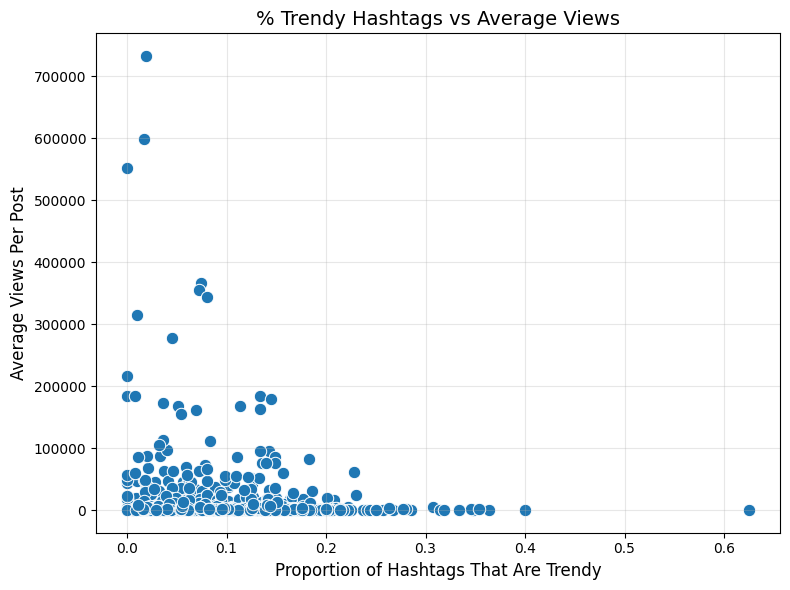

In [42]:
# scatterplot for % trendy vs avergae views 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=user_profile,
    x="trendy",          # % trendy hashtags
    y="avg_views",       # average views
    s=80
)

plt.title("% Trendy Hashtags vs Average Views", fontsize=14)
plt.xlabel("Proportion of Hashtags That Are Trendy", fontsize=12)
plt.ylabel("Average Views Per Post", fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
# correlation between usage of persistent hashtags and views 
user_profile[["persistent", "avg_views"]].corr()

,persistent,avg_views
persistent,1.000000,0.073939
avg_views,0.073939,1.000000


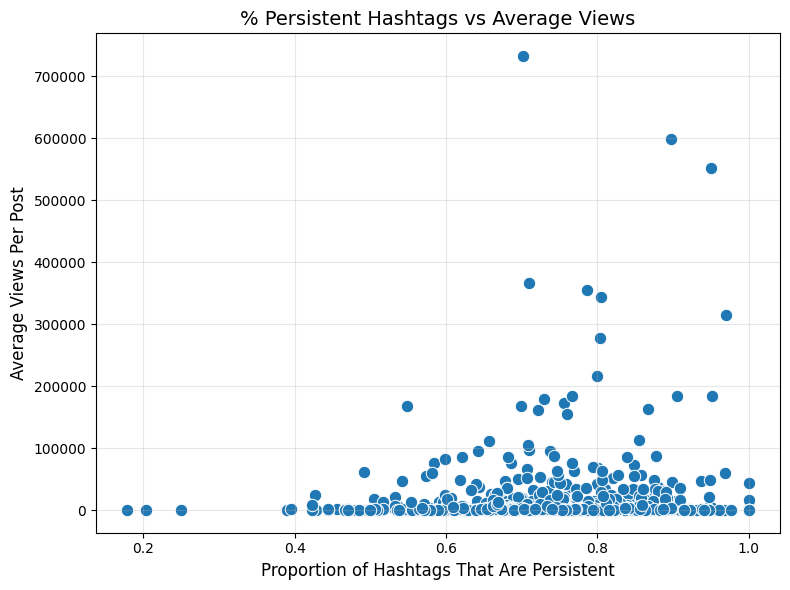

In [44]:
# scatterplot for % persistent vs avergae views 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=user_profile,
    x="persistent",          # % trendy hashtags
    y="avg_views",       # average views
    s=80
)

plt.title("% Persistent Hashtags vs Average Views", fontsize=14)
plt.xlabel("Proportion of Hashtags That Are Persistent", fontsize=12)
plt.ylabel("Average Views Per Post", fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# correlation between usage of moderate hashtags and views 
user_profile[["moderate", "avg_views"]].corr()

,moderate,avg_views
moderate,1.000000,-0.044734
avg_views,-0.044734,1.000000


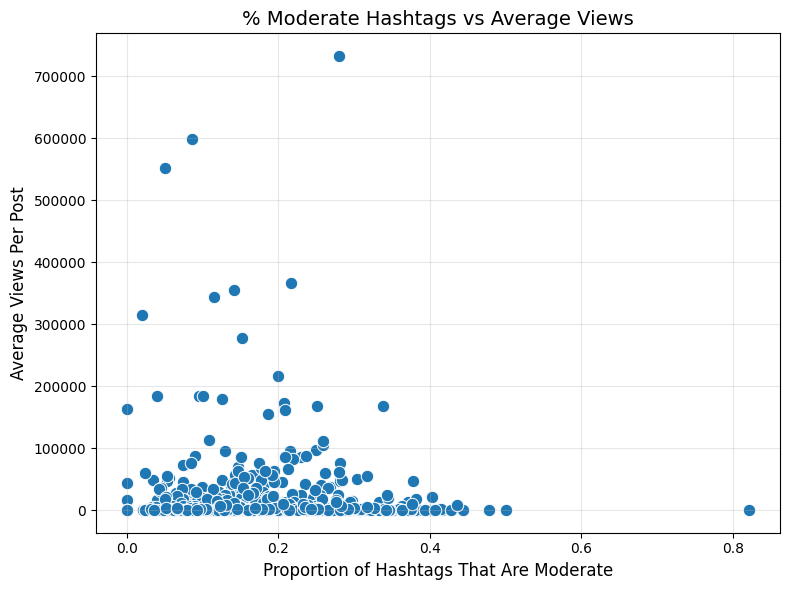

In [46]:
# scatterplot for % moderate vs avergae views 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=user_profile,
    x="moderate",          # % trendy hashtags
    y="avg_views",       # average views
    s=80
)

plt.title("% Moderate Hashtags vs Average Views", fontsize=14)
plt.xlabel("Proportion of Hashtags That Are Moderate", fontsize=12)
plt.ylabel("Average Views Per Post", fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [47]:
# comparing high view users versus low view users 
median_cutoff = user_profile["avg_views"].median()
high = user_profile[user_profile["avg_views"] > median_cutoff]
low  = user_profile[user_profile["avg_views"] <= median_cutoff]

high["trendy"].mean(), low["trendy"].mean()

(np.float64(0.07797379244798577), np.float64(0.0836341734468314))

In [48]:
high["persistent"].mean(), low["persistent"].mean()

(np.float64(0.7506530647591093), np.float64(0.7342104299109942))

In [49]:
# summary of hashtag behavior for low vs high view users
compare_df = pd.DataFrame({
    "avg_trendy": [high["trendy"].mean(), low["trendy"].mean()],
    "avg_persistent": [high["persistent"].mean(), low["persistent"].mean()],
    "avg_moderate": [high["moderate"].mean(), low["moderate"].mean()]
}, index=["High-View Users", "Low-View Users"])

compare_df

,avg_trendy,avg_persistent,avg_moderate
High-View Users,0.077974,0.750653,0.171373
Low-View Users,0.083634,0.734210,0.182155


## Modeling  

In [54]:
# tree classifier 
hashtag_model_df = df_clean.copy()

X = hashtag_model_df[["unique_days", "duration_days", "hashtag_frequency", "nr_unique_users"]]
y = hashtag_model_df["hashtag_category"]

In [55]:
# training the decesion tree 
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [56]:
# feature importance 
import pandas as pd

importance = pd.DataFrame({
    "feature": X.columns,
    "importance": dt.feature_importances_
})
importance

,feature,importance
0,unique_days,0.526772
1,duration_days,0.473228
2,hashtag_frequency,0.000000
3,nr_unique_users,0.000000


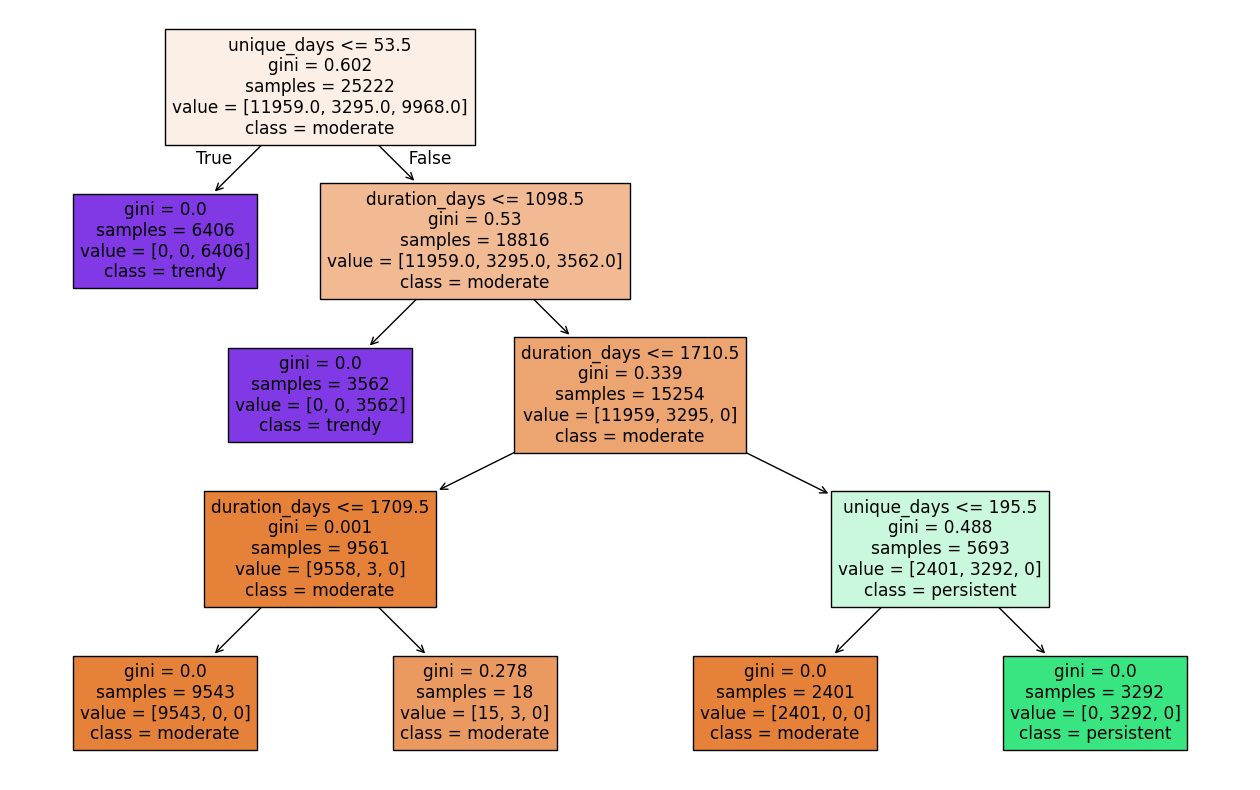

In [57]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
tree.plot_tree(dt, feature_names=X.columns, class_names=dt.classes_, filled=True)
plt.show()

### Regression

In [58]:
# computing the number of trending, persistent, and moderate hashtags per post
post_level = (
    df_expanded
    .groupby(["id", "username"], as_index=False)
    .agg(
        view_count=("view_count", "first"),
        like_count=("like_count", "first"),
        share_count=("share_count", "first"),
        comment_count=("comment_count", "first"),
        n_trendy=("hashtag_category", lambda x: (x == "trendy").sum()),
        n_persistent=("hashtag_category", lambda x: (x == "persistent").sum()),
        n_moderate=("hashtag_category", lambda x: (x == "moderate").sum()),
        total_hashtags=("hashtag_category", "count")
    )
)


In [59]:
# calculating the proportion of each hashtag category within each individual post 
post_level["pct_trendy"] = post_level["n_trendy"] / post_level["total_hashtags"]
post_level["pct_persistent"] = post_level["n_persistent"] / post_level["total_hashtags"]
post_level["pct_moderate"] = post_level["n_moderate"] / post_level["total_hashtags"]

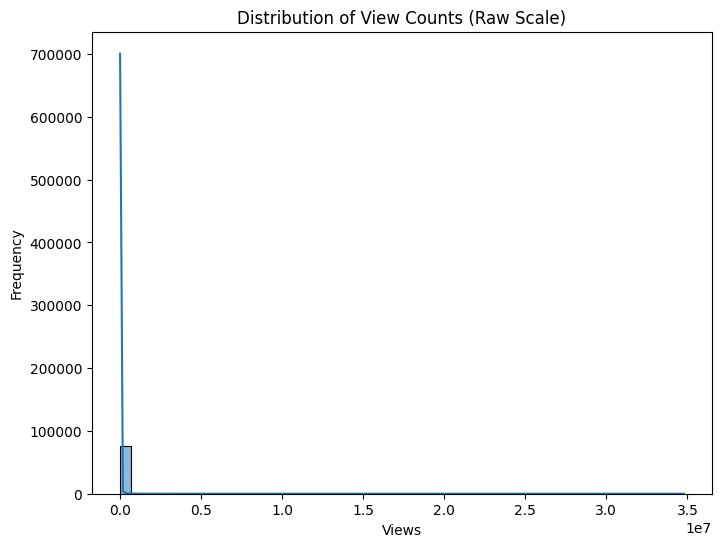

In [60]:
# checking if views are skewed 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(post_level["view_count"], bins=50, kde=True)
plt.title("Distribution of View Counts (Raw Scale)")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()

In [61]:
# logging views because they are skewed 
import numpy as np
import statsmodels.formula.api as smf

post_level["log_views"] = np.log1p(post_level["view_count"])

In [62]:
# fitting the model 
model = smf.ols(
    "log_views ~ pct_trendy + pct_persistent + pct_moderate",
    data=post_level
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     137.9
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           4.23e-89
Time:                        14:38:14   Log-Likelihood:            -1.5696e+05
No. Observations:               76576   AIC:                         3.139e+05
Df Residuals:                   76572   BIC:                         3.140e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -6.552e+10   7.22e+10     -0.

In [63]:
# adding user fixed effects
model_fe = smf.ols(
    "log_views ~ pct_trendy + pct_persistent + pct_moderate + C(username)",
    data=post_level
).fit()

print(model_fe.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     97.94
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:39:20   Log-Likelihood:            -1.2533e+05
No. Observations:               76576   AIC:                         2.527e+05
Df Residuals:                   75574   BIC:                         2.619e+05
Df Model:                        1001                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2